# Twitter sentient analysis using NLTK and Machine learning

In [1]:
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from nltk.corpus import stopwords

### Exploratory data analysis

In [3]:
cols = ['target','ids','date','flag','user','text']
df = pd.read_csv('twitter_dataset.csv', encoding="ISO-8859-1", names=cols)
df.sample(5)

,target,ids,date,flag,user,text
1407001,4,2055444861,Sat Jun 06 09:19:45 PDT 2009,NO_QUERY,lownleeeynjul,@Boy_Kill_Boy yup! Can DM it too if you want ...
152087,0,1932660868,Tue May 26 21:56:15 PDT 2009,NO_QUERY,EnglandRose,@rob_alexander hellz no boiiii. I'm good at th...
893401,4,1691862133,Sun May 03 18:46:07 PDT 2009,NO_QUERY,lotay,@heathermeeker I would read your blog!
804966,4,1468598407,Tue Apr 07 02:38:35 PDT 2009,NO_QUERY,lowcarbondiary,@karmadillo Thanks @juliankimmings sorted me ...
904224,4,1694791593,Mon May 04 04:08:19 PDT 2009,NO_QUERY,JMensing,Looking forward to a session at the gym


In [4]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [6]:
df['target'].unique()

array([0, 4], dtype=int64)

In [7]:
df.drop_duplicates(inplace=True)
df.shape

(1600000, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 85.4+ MB


In [9]:
df.groupby('target').count()

,ids,date,flag,user,text
target,,,,,
0,800000,800000,800000,800000,800000
4,800000,800000,800000,800000,800000


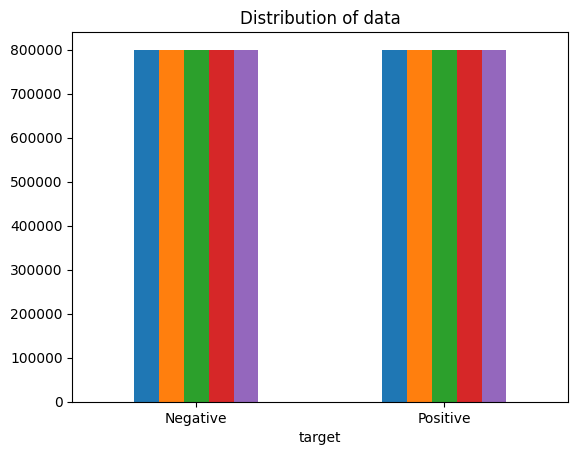

In [10]:
#data visualiation
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(df['text']), list(df['target'])

<AxesSubplot:xlabel='target', ylabel='count'>

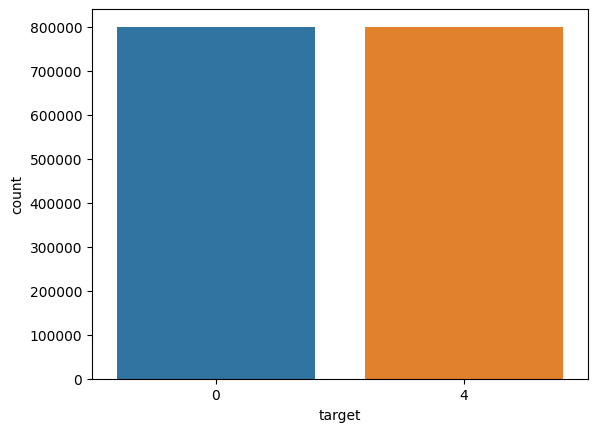

In [11]:
import seaborn as sns
sns.countplot(x='target', data=df)

In [12]:
data=df[['text','target']]
data.drop_duplicates(inplace=True)
data.shape

C:\Users\Amogh\AppData\Local\Temp\ipykernel_14972\2885864949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)


(1583691, 2)

In [13]:
data['target'] = data['target'].replace(4,1)
#assign 1 for positive for understanding

C:\Users\Amogh\AppData\Local\Temp\ipykernel_14972\2207005518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [14]:
data['target'].unique()

array([0, 1], dtype=int64)

In [21]:
data_pos = data[data['target']==1]
data_neg = data[data['target']==0]
print(data_pos.shape, data_neg.shape)

(793506, 2) (790185, 2)


In [22]:
# taking only 25k rows for understanding
data_pos = data_pos.iloc[:int(25000)]
data_neg = data_neg.iloc[:int(25000)]

In [23]:
print(data_pos.shape, data_neg.shape)

(25000, 2) (25000, 2)


In [79]:
dataset = pd.concat([data_pos, data_neg])
dataset.shape

(50000, 2)

In [80]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

25114    @jempolitico me too, howeeer i think the fries...
25115    @daskatzi apparently dust after a rewire will ...
25116    @tokyodriftmovie oh really?it is the warehouse...
25117    to my credit there i was traumatized by an inc...
25118      @versace5 it won't be the same without you!!!  
Name: text, dtype: object

In [81]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'been', 'before', 'or', 'doing', 'more', 'any', 'that', 'off', 'ours', 'above', 'their', 'needn', 'on', 'just', 'should', 've', 'won', 'here', 'below', 'against', 'for', 'shan', 'same', 'how', 'a', 'ain', 'whom', 'haven', "aren't", "wouldn't", 'until', 'no', "won't", 'each', 'himself', 'during', 'shouldn', 'can', "it's", 'm', 'then', 'you', 'will', 'both', 'y', 'll', 'themselves', 'him', 'hadn', 'am', 'them', 'he', 's', 'while', 'at', 'again', 'those', 'didn', 'mustn', 'because', 'hers', 'over', 'where', 'we', 'theirs', 'under', 'wasn', 'had', 'they', 'have', "she's", 'into', "shouldn't", 'such', 'when', 'be', "mustn't", 'after', "you've", "don't", 'now', 'me', 'has', 'too', 'doesn', "hasn't", 'i', 'her', 'ma', "shan't", 'between', 'few', 'out', 'not', 't', 'the', 'your', 'some', "you'd", 'its', 'myself', 'isn', "weren't", "mightn't", 'ourselves', 'with', "couldn't", 'most', 'was', 'from', 'my', 'but', 'she', 'are', 'were', 'having', "should've", 'yourselves', 'being', 'this', "you'll

### Remove stopwords, punctuations, numbers and links for obtaining more accuracy

In [82]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

In [84]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].head()

800000                   love health4uandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                       lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [85]:
punctuations_list

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [86]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

25114    jempolitico too howeeer think fries midnight p...
25115    daskatzi apparently dust rewire take months cl...
25116    tokyodriftmovie oh reallyit warehousehow cool ...
25117    credit traumatized incident pup sampson amp ba...
25118                                 versace5 without you
Name: text, dtype: object

In [87]:
dataset['text'].head()

800000                   love health4uandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                       lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [88]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

25114    jempolitico too howeeer think fries midnight p...
25115    daskatzi apparently dust rewire take months cl...
25116    tokyodriftmovie oh reallyit warehousehow cool ...
25117    credit traumatized incident pup sampson amp ba...
25118                                 versace5 without you
Name: text, dtype: object

In [89]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

25114    jempolitico too howeeer think fries midnight p...
25115    daskatzi apparently dust rewire take months cl...
25116    tokyodriftmovie oh reallyit warehousehow cool ...
25117    credit traumatized incident pup sampson amp ba...
25118                                  versace without you
Name: text, dtype: object

In [90]:
dataset['text'].head()

800000                    love healthuandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                        lovesbrooklyn effect everyone
Name: text, dtype: object

In [91]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
dataset['text'] = dataset['text'].apply(tt.tokenize)
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [92]:
dataset['text'].tail()

25114    [jempolitico, too, howeeer, think, fries, midn...
25115    [daskatzi, apparently, dust, rewire, take, mon...
25116    [tokyodriftmovie, oh, reallyit, warehousehow, ...
25117    [credit, traumatized, incident, pup, sampson, ...
25118                              [versace, without, you]
Name: text, dtype: object

### lemmatising the data

In [93]:
import nltk
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [94]:
from sklearn.utils import shuffle
dataset = shuffle(dataset)

In [95]:
def convert_to_text(list):
    return " ".join(list)
dataset['text'] = dataset['text'].apply(lambda x: convert_to_text(x))

In [96]:
dataset.head()

,text,target
818638,thats myspacecom haha,1
806841,shiminay fair enough surprisingly like it espe...,1
21118,keen big fat greasy double possibly triple che...,0
14259,bearnoiz shame died uh obviously know mean,0
7375,soo bored really wants go nottingham,0


In [97]:
#machine learning
#split data to x and y
X=dataset.text
y=dataset.target

### split the dataset, testing size of 20%

In [98]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [99]:
y_test.shape

(10000,)

In [100]:
x_train

806280                               aw women dead adorable
821395    rebeccahaswrote lol lotz types there know lotz...
18706            girl likelikes alcohol drugs way better me
3578                              httptwitpiccomy miss this
823408    the dandy cowboys soko rd soko blip httpblipfm...
                                ...                        
812061                                         couch potato
11983       tarafan aww badness hope buy another pretty one
815173    guess swollen neckshoulder again hmmmm must ca...
806226    johmoi no yet first time ive really disclosed ...
823274                        ready head vegas need new tat
Name: text, Length: 40000, dtype: object

### vectorising the data using TfidfVectoriser

In [102]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(x_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [103]:
x_train = vectoriser.transform(x_train)
x_test  = vectoriser.transform(x_test)

In [118]:
def evaluate_model(model):
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(cf_matrix)

### LinearRegression model

In [119]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(x_train, y_train)
evaluate_model(LRmodel)
y_pred1 = LRmodel.predict(x_test)

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      4995
           1       0.76      0.74      0.75      5005

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

[[3833 1162]
 [1324 3681]]


### SVM model

In [121]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)
evaluate_model(SVCmodel)
y_pred2 = SVCmodel.predict(x_test)

c:\users\amogh\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.74      0.77      0.75      4995
           1       0.76      0.73      0.75      5005

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

[[3834 1161]
 [1334 3671]]
